In [79]:
### imports
### 'd2' python environment
import numpy as np
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt
import time
import math
import sys
import os
import rasterio
import shapely

In [158]:
### read fire data file, print head to verify it worked
polygon_files = ["perim_data/east_troublesome_ts.gpkg"]
data = gpd.read_file(polygon_files[0])
print(data.head)
print(data.shape)
for i in range(data.shape[0]):
    if len(data.iloc[0]["geometry"].geoms) > 1:
        print(i)

<bound method NDFrame.head of             sim  id                     dates  \
0    experiment   1 2020-10-22 11:00:00+00:00   
1    experiment   2 2020-10-22 11:20:00+00:00   
2    experiment   3 2020-10-22 11:40:00+00:00   
3    experiment   4 2020-10-22 12:00:00+00:00   
4    experiment   5 2020-10-22 12:20:00+00:00   
..          ...  ..                       ...   
388        a_op   3 2020-10-24 01:30:30+00:00   
389        a_op   4 2020-10-24 13:29:52+00:00   
390        a_op   5 2020-10-24 20:37:52+00:00   
391        a_op   6 2020-10-24 22:45:47+00:00   
392        a_op   7 2020-10-25 01:29:47+00:00   

                                              geometry  
0    MULTIPOLYGON (((438538.814 4466012.402, 438538...  
1    MULTIPOLYGON (((438483.316 4466040.804, 438483...  
2    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
3    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
4    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
..                                     

In [159]:
### explore the shape of the data file
idx = 1
print(type(data.iloc[idx]["geometry"]))
print(len(data.iloc[idx]["geometry"].geoms))

print(data.iloc[idx]["geometry"].geoms[0].area)
#print(data.iloc[0]["geometry"].geoms[0].exterior)

print(len(data.iloc[idx]["geometry"].geoms[0].exterior.coords))
print(type(data.iloc[idx]["geometry"].geoms[0].exterior.coords))
simple_poly = data.iloc[idx]["geometry"].geoms[0].simplify(0.05).exterior
print(len(simple_poly.coords))
#print(simple_poly)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
1
411290.8838642978
2684
<class 'shapely.coords.CoordinateSequence'>
466


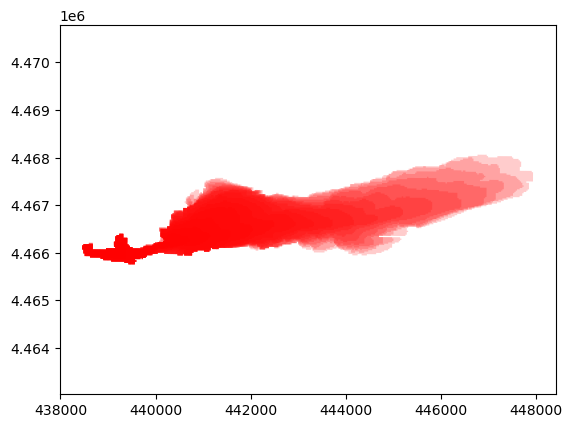

In [4]:
### plot progression of the fire
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')
runfor = 20
for i in range(runfor):
    xsi, ysi = data.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.xy   
    axs.fill(xsi, ysi, alpha=0.2, fc='r', ec='none')
#xs1, ys1 = data.iloc[1]["geometry"].geoms[0].simplify(0.05).exterior.xy 

plt.show()

In [124]:
### evaluate direct distance
def dist(a, b, params=None):
    return math.sqrt(((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2))

### TODO
### evaluate distance over terrain
def terraindist(a, b, distparams):
    terrain, steps_per_pix = distparams
    step_size = terrain.res[0]/steps_per_pix
    ### compute direct distance, use this to determine how many points to sample
    simple_dist = dist(a, b)
    n_samples = int(np.floor(simple_dist / step_size))
    ### check if the distance is long enough to sample, if so do that
    if n_samples > 0:
        ### regularly sample n_samples points between a and b
        ### my understanding is that the R code this is adapted from does NOT include
        ### the endpoints by default...

        ### . . ..  ### length = 5, step_size = 2 (0, 2, 4, (5))
        ### n_samples = floor(5/2) = 2
        ### regularly sample twice in the middle, once on each end...
        ### sample every s=(5/(2+1)) = 5/3... 0s, 1s, 2s, 3s, with n_samples+2 points

        total_dist = 0
        ### spatial steps
        vec_i = (b[0] - a[0]) / (n_samples+1)
        vec_j = (b[1] - a[1]) / (n_samples+1)
        ### sample elevations (more efficient to do all at once...?)
        elevs = list(elev_i[0] for elev_i in terrain.sample([(a[0] + vec_i * ii, a[1] + vec_j * ii) for ii in range(n_samples + 2)]))
        ### distance will be different than step_size due to regular sampling...
        step_dist = simple_dist/(n_samples+1)
        ### need to add the last point too! so n_samples+2 points
        for i in range(n_samples + 1):
            ### compute terrain distance with pythagorean theorem, step dist, elev. difference
            total_dist += math.sqrt((step_dist ** 2) + ((elevs[i+1] - elevs[i])**2))
        ### for bugfixing:
        if False:
            print(total_dist, simple_dist)
        return total_dist
    ### if not long enough to sample, only compare endpoints    
    else:
        ### sample elevations at start and endpoint
        elevs = list(elev_i[0] for elev_i in terrain.sample([a, b]))
        ### compute 3d-dist with horizontal, vertical differences
        total_dist = math.sqrt((simple_dist**2) + ((elevs[0] - elevs[1]) ** 2))
        return total_dist

In [118]:
### algorithm 1 -- naive max over min distances nearest neighbors
def nn_basic(gpd_dataset, stopat):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()

    ### get original inner perimeter
    step_n_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].exterior.coords
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        if i % 10 == 0:
            print("basic", i)

        step_n_0 = step_n_1
        step_n_1 = gpd_dataset.iloc[i]["geometry"].geoms[0].exterior.coords
        step_pairs = [] ### step_n_1 point with minimum distance
        step_dists = []  ### distance to nearest step_n_1 point
        ### iterate over inner points
        for j in range(len(step_n_0)):
            rolling_closest = None
            rolling_dist = float("inf")
            ### iterate over outer points to find closest
            for k in range(len(step_n_1)):
                tdist = dist(step_n_0[j], step_n_1[k])
                if tdist < rolling_dist:
                    rolling_dist = tdist
                    rolling_closest = k
            step_pairs.append(rolling_closest)
            step_dists.append(rolling_dist)

        step_orig = np.argmax([step_dists])
        step_max = step_dists[step_orig]
        step_dest = step_pairs[step_orig]
        #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([step_orig, step_dest])
        result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [ ]:
### algorithm 2 -- naive min/max knn with simplified geometries
def nn_simplified(gpd_dataset, stopat, distfunc, distparams, resample, resampleparams):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()

    perims_n_1 = len(gpd_dataset.iloc[0]["geometry"].geoms)
    perims_n_0 = 0
    ### get original inner perimeter and simplify geometry with tolerance 0.05
    ### make sure to get all polygons within multipolygon for spotting!
    if resample is None:
        step_n_1 = [gpd_dataset.iloc[0]["geometry"].geoms[ii].simplify(0.05).exterior.coords for ii in range(perims_n_1)]
    if resample is not None:
        step_n_1 = [resample(gpd_dataset.iloc[0]["geometry"].geoms[ii].simplify(0.05).exterior, resampleparams).coords for ii in range(perims_n_1)]
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        ### progress update
        if i % 10 == 0:
            print("simplified", i)

        ### move outer geometry to inner geometry
        step_n_0 = step_n_1
        perims_n_0 = perims_n_1
        perims_n_1 = len(gpd_dataset.iloc[i]["geometry"].geoms)
        ### get next outer geometry and simplify with tolerance 0.05
        ### first... spot check
        if resample is None:
            step_n_1 = [gpd_dataset.iloc[i]["geometry"].geoms[ii].simplify(0.05).exterior.coords for ii in range(perims_n_1)]
        if resample is not None:
            step_n_1 = [resample(gpd_dataset.iloc[i]["geometry"].geoms[ii].simplify(0.05).exterior, resampleparams).coords for ii in range(perims_n_1)]

        ### do overlap and spot checks...
        inter_matrix = np.zeros((step_n_0, step_n_1))
        for ii in range(perims_n_0):
            for jj in range(perims_n_1):
                inter_matrix[ii, jj] = gpd_dataset.iloc[i-1]["geometry"].geoms[ii].intersects(gpd_dataset.iloc[i]["geometry"].geoms[jj])
        print(inter_matrix)
        ### bug check
        if perims_n_0 == 1 and perims_n_1 == 1 and inter_matrix[0, 0] == False:
            print("uh oh", i)

        ### broadly, for points vi, vj and polys Px Py,
        ### minimize distances between vi and vj with i fixed (closest point to fixed point)
        ### maximize distances between vi and vjmax with vjmax the closest point to vi (furthest travelled between 2 polys)
        ### minimize distances between Px and Py with x fixed (closest polygon to the one looked at)
        ### maximize distances between Px and Pymax (furthest point from closest point on closest polygon)
        for polyid_n_1 in range(perims_n_1):
            buffer_poly = gpd_dataset.iloc[i]["geometry"].geoms[polyid_n_1].buffer(0.2)
            ### this checks if any previous perimeter is inside this one...
            ### if not, spotted
            spot_flag = not np.any(inter_matrix[:, polyid_n_1])
            polyids = []
            if spot_flag:
                ### in the R code, this is resampling to get more points per meter to get accurate estimate...?
                ### need to compare with all polygons
                polyids= [ii for ii in range(perims_n_0)]
            ### if it hasn't spotted, compare to all perims that fall inside:
            else:
                for ii in range(perims_n_0):
                    if inter_matrix[ii, polyid_n_1]:
                        polyids.append(ii)
            ### now...

            poly_step_orig = []
            poly_step_max = []
            poly_step_dest = []

            for polyid_n_0 in polyids:
                ### do distance...
                ### compare first between 
                step_pairs = [] ### step_n_1 point with minimum distance
                step_dists = []  ### distance to nearest step_n_1 point
                ### iterate over inner points
                for j in range(len(step_n_0[polyid_n_0])):
                    rolling_closest = None
                    rolling_dist = float("inf")
                    ### iterate over outer points to find closest
                    for k in range(len(step_n_1[polyid_n_1])):
                        tdist = distfunc(step_n_0[polyid_n_0][j], step_n_1[polyid_n_1][k], distparams)
                        if tdist < rolling_dist:
                            rolling_dist = tdist
                            rolling_closest = k
                    step_pairs.append(rolling_closest)
                    step_dists.append(rolling_dist)
                
                poly_step_orig.append(np.argmax([step_dists]))
                poly_step_max.append(step_dists[step_orig])
                poly_step_dest.append(step_pairs[step_orig])

            ### behavior here depends on whether the fire is a spot or not
            ### if it is spotting, we just want the closest point... otherwise need to verify line stays within buffer...
            if spot_flag:




                step_orig = np.argmax([step_dists])
                step_max = step_dists[step_orig]
                step_dest = step_pairs[step_orig]
                #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
                time_0 = time_1
                time_1 = time.time()
                result_time.append(time_1 - time_0)
                result_pair.append([step_orig, step_dest])
                result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [152]:
### setup -- need to take geometry and sample along boundary instead of inputs.
### TODO
def resample_perim(perim, pts_per_meter):
    perim_len = perim.length
    n_samples = math.floor(pts_per_meter * perim_len)
    sampled = [perim.interpolate(i * perim_len / (n_samples - 1)) for i in range(n_samples)]
    print(len(perim.coords), "-> resampled to ->", n_samples)
    return shapely.LinearRing(sampled)

### TODO -- does this work
def readraster(raster_loc, reproject_to=None):
    src = None
    if reproject_to is not None:
        os.system("gdalwarp -t_srs EPSG:" + str(reproject_to) + " -dstnodata -999 " + raster_loc + " " + 
                raster_loc[:-4] + "_" + str(reproject_to) + raster_loc[-4:])
        raster_loc = raster_loc[:-4] + "_" + str(reproject_to) + raster_loc[-4:]
        print("set raster loc to", raster_loc)
    return rasterio.open(raster_loc)

In [110]:
### set up experiments
elev_data = readraster("R_fire_speed/LC20_Elev_220_estes_park.tif", 32613)

Using internal nodata values (e.g. 32767) for image R_fire_speed/LC20_Elev_220_estes_park.tif.
Processing R_fire_speed/LC20_Elev_220_estes_park.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
set raster loc to R_fire_speed/LC20_Elev_220_estes_park_32613.tif


2504.3978049522475
125 <- resampled to <- 259
POINT (438538.81393937866 4466012.401930082)


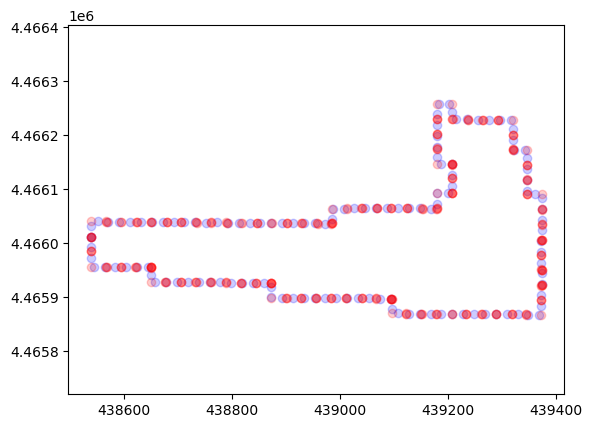

In [106]:
### plot progression of the fire
fig, axs = plt.subplots()
runon = 0
rate = 0.05
res_perim = resample_perim(data.iloc[runon]["geometry"].geoms[0].simplify(0.05).exterior, rate)
axs.set_aspect('equal', 'datalim')
xsa, ysa = res_perim.xy   
xsb, ysb = data.iloc[runon]["geometry"].geoms[0].simplify(0.05).exterior.xy
axs.scatter(xsa, ysa, alpha=0.2, color='b')
axs.scatter(xsb, ysb, alpha=0.2, color='r')
#xs1, ys1 = data.iloc[1]["geometry"].geoms[0].simplify(0.05).exterior.xy 

plt.show()

In [151]:
### run nn_trimmed experiment
print("comparing simplified basic")
nns_terrain = nn_simplified(data, 5, terraindist, [elev_data, 1], resample_perim, 0.05)
nns_basic = nn_simplified(data, 5, dist, [], None, None)

comparing simplified basic
2504.3978049522475
125 <- resampled to <- 259
POINT (438538.81393937866 4466012.401930082)
4555.4880064080035
227 <- resampled to <- 466
POINT (438483.31583092775 4466040.803579322)
5385.051479850275
269 <- resampled to <- 554
POINT (438455.67784837744 4466096.885916262)
6823.915939896677
341 <- resampled to <- 694
POINT (438455.67784837744 4466096.885916262)
8260.335392702884
413 <- resampled to <- 836
POINT (438455.67784837744 4466096.885916262)


[453.2605481147766]


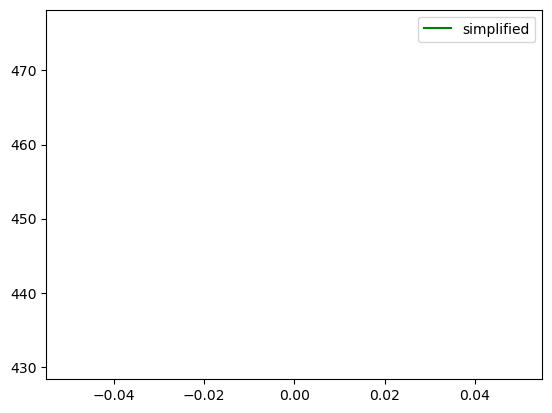

In [113]:
### step one -- compare times...
fig, axs = plt.subplots()
itersteps = np.arange(len(nns_res[2]))
#axs.plot(itersteps, nnb_res[2], color="red", label="basic")
axs.plot(itersteps, nns_res[2], color="green", label="simplified")
axs.legend()

print(nns_res[2])

plt.show()

In [148]:
### idea -- some get bounding boxes, grid out, bin, establish which are closest...
### i didn't hear who you said I should talk to about transformers ...
def nn_binned(gpd_dataset, stopat, max_bins, distfunc, distparams, resample, resampleparams, slop=1):
    root2 = round(math.sqrt(2), 5)
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()
    
    ### get original inner perimeter and simplify geometry with tolerance 0.05
    if resample is None:
        step_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].simplify(0.05).exterior
    if resample is not None:
        step_1 = resample(gpd_dataset.iloc[0]["geometry"].geoms[0].simplify(0.05).exterior, resampleparams)
    ### iterate over time steps
    for index in range(1, min(gpd_dataset.shape[0], stopat)):
        if index % 10 == 0:
            print("simplified", i)
        ### need to get this from shapes
        ### UL x, y LR x, y
        step_0 = step_1
        step_1 = gpd_dataset.iloc[index]["geometry"].geoms[0].simplify(0.05).exterior
        bbox_0 = step_0.bounds
        bbox_1 = step_1.bounds
        bbox = (min(bbox_0[0], bbox_1[0]), min(bbox_0[1], bbox_1[1]), max(bbox_0[2], bbox_1[2]), max(bbox_0[3], bbox_1[3]))
        bins_x = math.ceil((bbox[2] - bbox[0])/max_bins)
        bins_y = math.ceil((bbox[3] - bbox[1])/max_bins)
        bin_res = max(bins_x, bins_y)
        grid_size = (math.ceil((bbox[2] - bbox[0])/bin_res), math.ceil((bbox[3] - bbox[1])/bin_res))
        grid_spatial = (grid_size[0] * bin_res, grid_size[1] * bin_res)
        grid_offset = ((grid_spatial[0] - (bbox[2] - bbox[0]))/2, (grid_spatial[1] - (bbox[3] - bbox[1]))/2)
        ### now make np array w/ coarser side...
        bins_0 = np.zeros(grid_size, dtype=object)
        occu_0 = np.zeros(grid_size, dtype=bool)
        bins_1 = np.zeros(grid_size, dtype=object)
        occu_1 = np.zeros(grid_size, dtype=bool)
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                bins_0[i, j] = [] 
                bins_1[i, j] = []

        lower = (bbox[0] - grid_offset[0], bbox[1] - grid_offset[1])
        if resample is None:
            s0c = step_0.coords
            s1c = step_1.coords
        if resample is not None:
            s0c = resample(step_0, resampleparams).coords
            s1c = resample(step_1, resampleparams).coords
        s0c = step_0.coords
        s1c = step_1.coords

        for i in range(len(s0c)):
            ### bin inner layer
            s0c_ids = (int((s0c[i][0]-lower[0])//bin_res), (int(s0c[i][1]-lower[1])//bin_res))
            bins_0[s0c_ids[0], s0c_ids[1]].append(i)
            occu_0[s0c_ids[0], s0c_ids[1]] = True

        for i in range(len(s1c)):
            ### bin outer layer
            s1c_ids = (int((s1c[i][0]-lower[0])//bin_res), (int(s1c[i][1]-lower[1])//bin_res))
            bins_1[s1c_ids[0], s1c_ids[1]].append(i)
            occu_1[s1c_ids[0], s1c_ids[1]] = True

        ### get list of occupied bins
        #ocid_0 = np.argwhere(occu_0 == True)
        ocid_1 = np.argwhere(occu_1 == True) 

        sample_pair = None
        sample_dist = float("-inf")

        ### do root2 rings... focus on points in outer perim
        ### iterate over occupied bins in outer ring to narrow comparison
        for occu_loc in ocid_1:
            ### start at the center bin and iteratively look further until we find all squares...
            ### withing 2sqrt(2) + slop of the closest point we find
            ### expand out until we find all squares with UL distance of 2sqrt(2) of the closest
            ### start with this loose upper bound because this is the furthest we can possibly iterate 
            ### ...because there are only so many bins...
            root2_dist = max_bins ### needs some work... to tighten upper bound?
            root2_set = True
            ring = 0
            ring_sqs = None
            ring_offset = None
            ### while the ring is within the upper bound
            while ring < root2_dist:
                ### get shortlist of occupied bins (inner perim) within the ring
                temp = np.argwhere(occu_0[max(occu_loc[0]-ring, 0): min(occu_loc[0]+ring+1, grid_size[0] - 1), 
                                        max(occu_loc[1]-ring, 0): min(occu_loc[1]+ring+1, grid_size[1] - 1)]==True)
                ### if there are occupied bins in this ring, and we haven't found an occupied bin yet, 
                ### we can cap the number of rings with a loose-ish upper bound of the L1-distance
                ### in which we could find a point with a smaller L2-distance
                if len(temp) > 0 and root2_set:
                    root2_dist = math.ceil(math.sqrt(2) * (ring + 1)) + slop
                    root2_set = False
                ### if we have reached the upper bound and have found points...
                ### set nearest-neighbor-check shortlist to temp
                if ring+1 >= root2_dist and not root2_set:
                    ring_sqs = temp
                    ### need to compute lower coords of ring... because temp locations are relative to this 
                    ring_offset = [max(occu_loc[0]-ring, 0), max(occu_loc[1]-ring, 0)]
                ring += 1
        
            ### for each outer box (occu_loc) we have a series of points (len(bins_1[][])) -- 
            ###     for each point we have a series of inner boxes (ring_sqs[][][i/j])
            ###         for each inner box we have a series of points --- measure distances and find min
            spair = None
            sdist = float("-inf")
            n_checks = 0
            ### iterate over every point in this outer-perim bin
            for k in range(len(bins_1[occu_loc[0], occu_loc[1]])):
                tpair = None
                tdist = float("inf")
                ### iterate over every occupied bin found in the ring process..
                for i in range(len(ring_sqs)):
                    ### get list of points from occupied bin i
                    temp_box_0 = bins_0[ring_sqs[i][0] + ring_offset[0], ring_sqs[i][1] + ring_offset[1]]
                    ### iterate over every point in this box
                    for l in range(len(temp_box_0)):
                        ### we can NOW compare distances between every point in the central outer-perim bin and every
                        ### point in this inner-perim bin
                        temp_dist = distfunc(s1c[bins_1[occu_loc[0], occu_loc[1]][k]], s0c[temp_box_0[l]], distparams)
                        ### check if we have found a new shortest pair...
                        ### this results in a shortest-pair combination for every point in this outer bin
                        if temp_dist < tdist:
                            tpair = (temp_box_0[l], bins_1[occu_loc[0], occu_loc[1]][k])
                            tdist = temp_dist
                        n_checks += 1
                ### now having compared all inner samples to this point...
                ### we can compare the shortest-pair distance we found to the other ones in this bin...
                ### and hold on to the longest of them...
                if tdist > sdist:
                    spair = tpair
                    sdist = tdist
            ### now we can compare the longest shortest-pair combo we found from this bin to the ones
            ### found in other bins...
            ### TODO -- some way to account for ties...
            if sdist > sample_dist:
                sample_dist = sdist
                sample_pair = spair
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([s0c[sample_pair[0]], s1c[sample_pair[1]]])
        result_dist.append(sample_dist)
    return result_pair, result_dist, result_time

In [149]:
print("comparing binned (200)")
bin_res = nn_binned(data, 5, 200, terraindist, [elev_data, 1], resample_perim, 0.05)

comparing binned (200)
2504.3978049522475
125 <- resampled to <- 259
POINT (438538.81393937866 4466012.401930082)
2409.00758702701
120 <- resampled to <- 125
POINT (438538.81393937866 4466012.401930082)
4555.4880064080035
227 <- resampled to <- 466
POINT (438483.31583092775 4466040.803579322)
4555.4880064080035
227 <- resampled to <- 466
POINT (438483.31583092775 4466040.803579322)
5385.051479850275
269 <- resampled to <- 554
POINT (438455.67784837744 4466096.885916262)
5385.051479850275
269 <- resampled to <- 554
POINT (438455.67784837744 4466096.885916262)
6823.915939896677
341 <- resampled to <- 694
POINT (438455.67784837744 4466096.885916262)
6823.915939896677
341 <- resampled to <- 694
POINT (438455.67784837744 4466096.885916262)
8260.335392702884
413 <- resampled to <- 836
POINT (438455.67784837744 4466096.885916262)


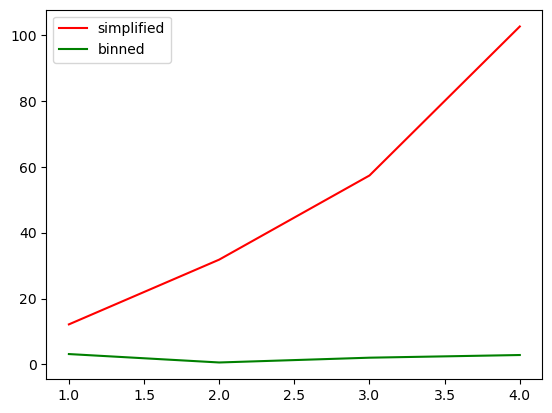

In [156]:
### step one -- compare times...
fig, axs = plt.subplots()
itersteps_1 = np.arange(len(nns_terrain[2])) + 1
itersteps_2 = np.arange(len(bin_res[2])) + 1
axs.plot(itersteps_1, nns_terrain[2], color="red", label="simplified")
axs.plot(itersteps_2, bin_res[2], color="green", label="binned")
axs.legend()

plt.show()

In [ ]:
#spot-check...